<a href="https://colab.research.google.com/github/WilliamPoe/CSCI-290/blob/main/notebooks/asm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
def Gini_Impurity(df, attribs, target):
    gini = 0
    lowest_gini = float('inf')
    split_point = 0
    lowest_quant_gini = float('inf')
    quant_attrib = ''
    overall = len( df )
    for attrib in attribs: ### change this to df.columns ###
      vals = df[attrib].unique()
      # Quantitative Gini Impurity Calc
      if df[attrib].dtype in ['float64', 'int64']:
        if len( df[attrib].unique() ) > 10:
          vals.sort()
          overall = len( df )
          gini_impurities = []
          for val in vals:
            quant_gini = 0
            left = df[ df[attrib] <= val ][ [attrib,target] ]
            props = left[ target ].value_counts( normalize = True ) ## Left Probabilities calculation
            weight = len( left ) / overall ## Left Weight calculation
            for prop in props.array:
              quant_gini += weight*(1-(prop**2)) ## Gini calculation
            right = df[ df[attrib] > val ][ [attrib,target] ]
            props = right[ target ].value_counts( normalize = True ) ## Right Probabilities calculation
            weight = len( right ) / overall ## Right Weight calculation
            for prop in props.array:
              if prop > 0:
                ### Change calculation ###
                quant_gini += weight*(1-(prop**2)) ## Gini calculation
              gini_impurities.append(quant_gini)
          index = pd.Series( gini_impurities ).idxmin()
          # Check to see if there is a new lowest Gini Impurity
          if gini_impurities[index] < lowest_quant_gini:
            # Lowest Gini Impurity
            lowest_quant_gini = gini_impurities[index]
            # Split point with lowest Gini Impurity
            split_point = vals[index]
            # Attribute that has the split point
            quant_attrib = attrib

      # Categorical Gini Impurity Calc
      else:
        for val in vals:
          subset_size = len(df[ df[attrib] == val ]) ## Get size of subset
          weight = subset_size / overall ## Subset Weight calculation
          props = df[ df[attrib] == val ][target].value_counts( normalize=True ) ## Probabilities calculation
          for p in props.array:
            gini +=  weight*(1-(p**2)) ## Gini calculation
        # If new gini is smaller then current
        if lowest_gini > gini:
          # Lowest Gini Impurity
          lowest_gini = gini
          # Attribute that has that Gini Impurity
          lowest_attrib = attrib
    # Compares the lowest categorical Gini Impurity with the lowest quantitative Gini Impurity
    if lowest_gini < lowest_quant_gini:
      # If categorical Gini Impurity is still lowest
      return lowest_attrib, lowest_gini
    else:
      # If quantitative Gini Impurity is lowest
      lowest_gini = lowest_quant_gini
      lowest_attrib = quant_attrib
      return lowest_attrib, split_point, lowest_gini

In [4]:
def Entropy (df, attribs, target):
    entropy = 0
    lowest_entropy = float('inf')
    split_point = 0
    lowest_quant_entropy = float('inf')
    quant_attrib = ''
    overall = len( df )
    for attrib in attribs: ### change this to df.columns ###
      vals = df[attrib].unique()
      # Quantitative Entropy Calc
      if df[attrib].dtype in ['float64', 'int64']:
        if len( df[attrib].unique() ) > 10:
          vals.sort()
          overall = len( df )
          entropies = []
          for val in vals:
            quant_entropy = 0
            left = df[ df[attrib] <= val ][ [attrib,target] ]
            props = left[ target ].value_counts( normalize = True ) ## Left Probabilities calculation
            weight = len( left ) / overall ## Left Weight calculation
            for prop in props.array:
              quant_entropy = quant_entropy - weight*prop*math.log2( prop ) ## Entropy calculation
            right = df[ df[attrib] > val ][ [attrib,target] ]
            props = right[ target ].value_counts( normalize = True ) ## Right Probabilities calculation
            weight = len( right ) / overall ## Right Weight calculation
            for prop in props.array:
              if prop > 0:
                quant_entropy = quant_entropy - weight*prop*math.log2( prop ) ## Entropy calculation
              entropies.append(quant_entropy)
          index = pd.Series( entropies ).idxmin()
          # Check to see if there is a new lowest Entropy
          if entropies[index] < lowest_quant_entropy:
            # Lowest entropy
            lowest_quant_entropy = entropies[index]
            # Split point with lowest entropy
            split_point = vals[index]
            # Attribute that has the split point
            quant_attrib = attrib

      # Categorical Entropy Calc
      else:
        for val in vals:
          subset_size = len(df[ df[attrib] == val ]) ## Get size of subset
          weight = subset_size / overall ## Subset Weight calculation
          props = df[ df[attrib] == val ][target].value_counts( normalize=True ) ## Probabilities calculation
          for prop in props.array:
            entropy =  entropy - weight*(prop*math.log2(prop)) ## Entropy calculation
        # If new entropy is smaller then current
        if lowest_entropy > entropy:
          # Lowest Entropy
          lowest_entropy = entropy
          # Attribute that has that Entropy
          lowest_attrib = attrib
    # Compares the lowest categorical Entropy with the lowest quantitative Entropy
    if lowest_entropy < lowest_quant_entropy:
      # If categorical entropy is still lowest
      return lowest_attrib, lowest_entropy
    else:
      # If quantitative entropy is lowest
      lowest_entropy = lowest_quant_entropy
      lowest_attrib = quant_attrib
      return lowest_attrib, split_point, lowest_entropy

In [5]:
def classification(X_train, X_test, y_train, y_test, method, pipeline):

  ### Gini Impurity method ###
  if method == "gini":
    result = Gini_Impurity(df, X_train, y_train.name) # Calls Gini Impurity Function to claculate gini
    print("Gini Impurity result:", result)

  ### Entropy method ###
  elif method == "entropy":
    result = Entropy(df, X_train, y_train.name)  # Calls Entropy function to calculate entropy
    print("Entropy result:", result)

  ### Invalid method ###
  else:
    print("Invalid Method")
    return

  ## DecisionTreeClassifier ###

  ### Fits the training data to the pipline ###
  pipeline.fit(X_train, y_train)
  ### Predicts the test data ###
  y_pred = pipeline.predict(X_test)
  ### Calculates the accuracy score ###
  accuracy = accuracy_score(y_test, y_pred)
  ### Plots the decision tree ###
  plot_tree(pipeline.named_steps['clf'], filled=True, rounded=True, fontsize=6)
  return accuracy


In [6]:
def regression(X_train, X_test, y_train, y_test, pipeline):
  lowest_mse = float('inf')
  split_point = None
  lowest_attrib = None
  overall = len(df)

  for attrib in df.columns:
    if attrib == target:
      continue

    vals = df[attrib].unique()

    # Quantitative Mean Squared Error Calc
    if np.issubdtype(df[attrib].dtype, np.number):
      if len(vals) > 10:
          vals.sort()
          mses = []
          for val in vals:
            left = df[df[attrib] <= val][target]
            right = df[df[attrib] > val][target]

            mse_left = np.mean((left - np.mean(left)) ** 2) if len(left) > 0 else 0 ## MSE calculation
            mse_right = np.mean((right - np.mean(right)) ** 2) if len(right) > 0 else 0 ## MSE calculation

            # Weighted average of MSE
            weight_left = len(left) / overall ## Left Weight calculation
            weight_right = len(right) / overall ## Right Weight calculation
            weighted_mse = weight_left * mse_left + weight_right * mse_right ## Weighted MSE calculation
            mses.append(weighted_mse)

          index = pd.Series(mses).idxmin()
          # Check to see if there is a new smallest MSE
          if mses[index] < lowest_mse:
            # Lowest mean squared error
            lowest_mse = mses[index]
            # Split point with the lowest mean squared error
            split_point = vals[index]
            # Attribute that has the split point
            lowest_attrib = attrib

        # Categorical Mean Squared Error Calc
      else:
        for val in vals:
          left = df[df[attrib] == val][target]
          right = df[df[attrib] != val][target]

          mse_left = np.mean((left - np.mean(left)) ** 2) if len(left) > 0 else 0 ## MSE calculation
          mse_right = np.mean((right - np.mean(right)) ** 2) if len(right) > 0 else 0 ## MSE calculation

          # Weighted average of MSE
          weight_left = len(left) / overall ## Left Weight calculation
          weight_right = len(right) / overall ## Right Weight calculation
          weighted_mse = weight_left * mse_left + weight_right * mse_right ## Weighted MSE calculation
          # Check to see if there is a new smallest MSE
          if weighted_mse < lowest_mse:
            # Lowest mean squared error
            lowest_mse = weighted_mse
            # Split point with the lowest mean squared error
            split_point = val
            # Attribute that has the split point
            lowest_attrib = attrib

  ## add print statement ##
  print("The best split is with the lowest Mean Squared Error:", lowest_attrib, split_point, lowest_mse)

  ### Fits the training data to the pipline ###
  pipeline.fit(X_train, y_train)

  ### Predicts the test data ###
  y_pred = pipeline.predict(X_test)

  ### Calculates the mean squared error ###

  ## DecisionTreeRegressor ##

  ### Calculates the mean squared error ###
  mse = mean_squared_error(y_test, y_pred)
  ### Plots the decision tree ###
  plot_tree(pipeline.named_steps['clf'], filled=True, rounded=True, fontsize=7)
  return "Mean Squared Error:", mse


In [11]:
def Attribute_selection_method(task, df, target):

  ### Split the data ###
  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  ### Process the data ###
  num_attributes = X_train.select_dtypes( include = ['float64']).columns
  cat_attributes = X_train.select_dtypes( include = ['object']).columns

  trf = [ ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
         ('Scaler', StandardScaler())]),
         num_attributes), ('cat', OneHotEncoder( handle_unknown='ignore' ), cat_attributes) ]
  col_transform = ColumnTransformer( transformers = trf )

  ### Classification task ###
  if task.lower() == "classification":
    method = input("Enter the method of attribute selection (gini or entropy): ").lower()
    ### NOT 100% SURE THIS IS WHAT CAN BE DONE ###
    pipeline = Pipeline( steps = [('pre', col_transform),
('clf', DecisionTreeClassifier(max_depth=2))])
    ### Function call ###
    print(classification(X_train, X_test, y_train, y_test, method, pipeline))

  ### Regression task ###
  elif task.lower() == "regression":
    ### Pipeline for regression ###
    pipeline = Pipeline( steps = [('pre', col_transform),
('clf', DecisionTreeRegressor(max_depth = 2))])
    ### Function call ###
    print(regression(X_train, X_test, y_train, y_test, pipeline))

  ### Invalid task ###
  else:
    print("Invalid Task")
    return

The best split is with the lowest Mean Squared Error: remote_ratio 0 0.4375224322261141
('Mean Squared Error:', 0.3458557636600518)


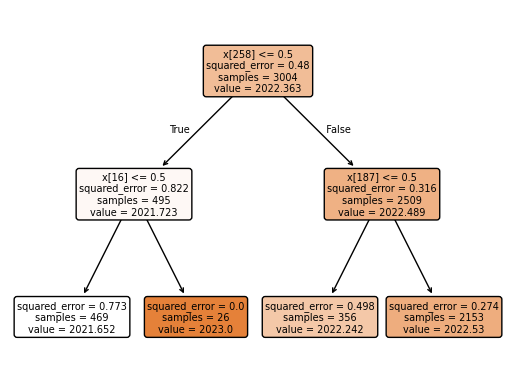

In [12]:
df = pd.read_csv("https://raw.githubusercontent.com/WilliamPoe/CSCI-290/refs/heads/main/Data/ds_salaries.csv") ## Dataset
#target = "experience_level" ## Categorical target attribute
target = "work_year" ## Numerical target attribute
#task = "classification" ## For Classification
task = "regression" ## For Regression
Attribute_selection_method(task, df, target)